In [1]:
from model.LinearModel import LinearRegression
import pandas as pd
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
from utils import *

In [2]:
# load FinTech data
set_rand_seed(1)
df = pd.read_csv('./data/FinTech.csv', encoding='utf-8')
df.head()

Random Seed:  1


,DXYUSD_Open,DXYUSD_High,DXYUSD_Low,DXYUSD_Close,DXYUSD_AdjClose,World_Index_Open,World_Index_High,World_Index_Low,World_Index_Close,World_Index_AdjClose,...,DJCI_volatility,CrudeOil_Return,CrudeOil_volatility,SPY_Return,SPY_volatility,VIX_Return,VIX_volatility,TNXTbill_Return,TNXTbill_volatility,Return
0,82.160004,82.269997,81.599998,81.730003,81.730003,61.549999,62.000000,61.549999,62.000000,52.829594,...,0.070000,-0.011005,1.760002,0.002385,1.110000,-0.013858,0.77,0.004197,0.041,-0.115983
1,81.709999,81.739998,81.330002,81.639999,81.639999,61.389999,61.389999,61.389999,61.389999,52.309818,...,0.090000,-0.026000,3.150001,-0.008767,1.309998,0.071746,0.80,-0.021493,0.044,-0.120081
2,81.620003,82.349998,81.510002,82.209999,82.209999,62.349998,62.650002,62.349998,62.650002,53.383457,...,0.800000,0.032517,3.599998,0.009287,1.360000,-0.062112,0.90,-0.004881,0.041,0.300187
3,82.220001,82.519997,81.910004,82.099998,82.099998,63.779999,65.470001,60.580002,63.000000,53.681683,...,0.019998,0.017236,2.480003,0.010141,2.100006,-0.054452,0.38,0.074188,0.125,-0.100820
4,81.980003,82.410004,81.980003,82.320000,82.320000,64.500000,64.599998,63.500000,63.630001,54.218506,...,0.119999,0.005753,2.320000,0.002541,0.589997,-0.014786,0.53,0.010845,0.038,0.058647


In [3]:
# Divide the data set into inputs and outputs
df_input = df.drop(['Return'], axis=1).values
df_ouput = df[['Return']].values
df_input.shape, df_ouput.shape
# df_input = df.drop(['BTC_Price'], axis=1)
# df_ouput = df[['BTC_Price']]
# df_input.shape, df_ouput.shape


n_samples, n_features = df_input.shape[0], df_input.shape[-1]
print(df_input.shape, df_ouput.shape)
# split data to train and test set
# X_train, X_test, Y_train, Y_test = train_test_split(df_input, df_ouput, test_size=0.2, random_state=1, shuffle=True)
n_train = int(n_samples * 0.8)
X_train, X_test = df_input[:n_train], df_input[n_train:]
Y_train, Y_test = df_ouput[:n_train], df_ouput[n_train:]


# # Normalized data (mean:0, std:1)
X_train_scaler = StandardScaler()
Y_train_scaler = StandardScaler()
X_test_scaler = StandardScaler()
Y_test_scaler = StandardScaler()

X_train = X_train_scaler.fit_transform(X_train)
X_test = X_test_scaler.fit_transform(X_test)
Y_train = Y_train_scaler.fit_transform(Y_train)
Y_test = Y_test_scaler.fit_transform(Y_test)

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(1910, 71) (1910, 1)
(1528, 71) (1528, 1) (382, 71) (382, 1)


In [4]:
# # # using all examples for training
# X_train, Y_train = df_input.values, df_ouput.values
# X_test = copy.deepcopy(X_train)
# Y_test = copy.deepcopy(Y_train)

In [4]:
time_step=1
n_features = X_train.shape[1]
# built timeseries data for LSTM
def time_sequence(X, Y, time_step=time_step):
    n_samples = X.shape[0]
    X_data = np.zeros([n_samples-time_step+1, time_step * n_features])
    Y_data = Y[time_step-1:, :]
    n_samples = X_data.shape[0]

    for i in range(n_samples):
        X_data[i, :] = X[i:i+time_step, :].reshape(1, -1)
    return X_data, Y_data
X_train, Y_train = time_sequence(X_train, Y_train)
X_test, Y_test = time_sequence(X_test, Y_test)

In [5]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1528, 71), (1528, 1), (382, 71), (382, 1))

In [6]:
Y_train.mean(axis=0), Y_train.std(axis=0), Y_test.mean(axis=0), Y_test.std(axis=0)

(array([9.30029759e-18]), array([1.]), array([0.]), array([1.]))

In [8]:
# import pandas as pd
# import seaborn as sns
# from scipy.stats import *
# import matplotlib.pyplot as plt
# plt.figure(figsize=(12,9))
# for i in range(df_input.shape[1]):
#     plt.figure(1)
#     ax1 = sns.distplot(X_train[:,i],kde_kws={"label":"train_set"})
#     ax2 = sns.distplot(X_test[:,i],kde_kws={"label":"test_set"})
#     plt.title(df_input.columns[i])
#     plt.show()
# #     time.sleep(1)

In [7]:
LR = LinearRegression()
LR.fit(X_train, Y_train, verbose=True, max_iters=10000, lr=1e-2, print_freq=1000, tol=1e-8)
LR.R2_score(X_train, Y_train), LR.MSE(X_train, Y_train)

iteration:1000	 loss:0.497870
iteration:2000	 loss:0.497746
iteration:3000	 loss:0.497676
iteration:4000	 loss:0.497628
iteration:5000	 loss:0.497591
iteration:6000	 loss:0.497561
iteration:7000	 loss:0.497536
iteration:8000	 loss:0.497514
iteration:9000	 loss:0.497495
iteration:10000	 loss:0.497479


(0.001081270188471948, 0.9949572264623799)

In [8]:
def accuracy1(preds, y):
    SSE = np.sum(np.square(y - preds))
    SST = np.sum(np.square(y - np.mean(y)))
    return 1 - (SSE/SST)

def accuracy2(preds, y):
    SSR = np.sum(np.square(preds - np.mean(y)))
    SST = np.sum(np.square(y - np.mean(y)))
    return (SSR/SST)

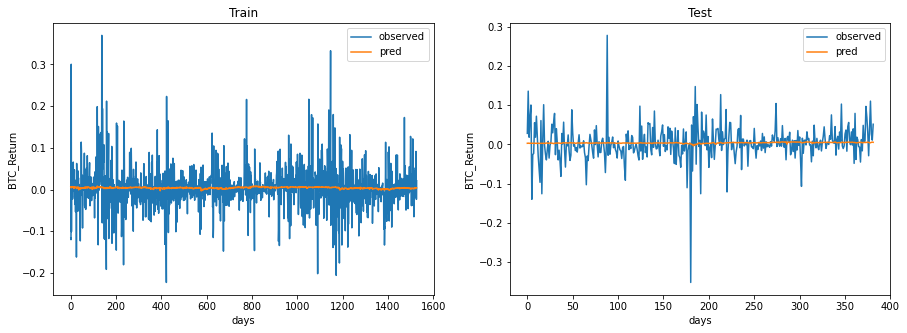

R2_1	R2_2	MSE	mean_MSE
0.00504277353762006 0.001081270188471948 0.0024602355518665987 0.0024893746256910315
0.0002918436322667528 0.0007890056975259858 0.002041210160276727 0.0020580229587582313


In [9]:
# inverse normalized
train_pre = LR.predict(X_train)
test_pre = LR.predict(X_test)

train_pre = Y_train_scaler.inverse_transform(train_pre)
yytrain = Y_train_scaler.inverse_transform(Y_train)
test_pre = Y_test_scaler.inverse_transform(test_pre)
yytest = Y_test_scaler.inverse_transform(Y_test)

# plot prediction and true values
#进行绘图
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(yytrain)
plt.plot(train_pre)
plt.xlabel('days')
plt.ylabel('BTC_Return')
plt.legend(['observed', 'pred'])
plt.title('Train')
plt.subplot(122)
plt.plot(yytest)
plt.plot(test_pre)
plt.xlabel('days')
plt.ylabel('BTC_Return')
plt.legend(['observed', 'pred'])
plt.title('Test')
plt.show()

from sklearn.metrics import r2_score, mean_squared_error
print("R2_1\tR2_2\tMSE\tmean_MSE")
print(accuracy1(train_pre, yytrain), accuracy2(train_pre, yytrain), mean_squared_error(train_pre, yytrain), mean_squared_error(np.zeros([yytrain.shape[0], 1]), yytrain))
print(accuracy1(test_pre, yytest), accuracy2(test_pre, yytest), mean_squared_error(test_pre, yytest), mean_squared_error(np.zeros([yytest.shape[0], 1]), yytest))

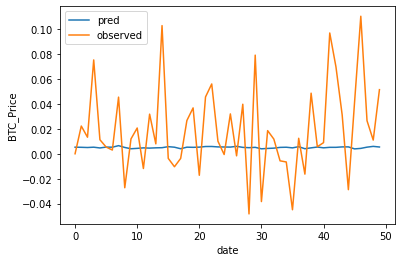

(-1266.0480827989309, 0.0018798267040038813)

In [10]:
from sklearn.metrics import r2_score
# inverse normalized
pre = LR.predict(X_test)
predY = Y_test_scaler.inverse_transform(pre)
yytest = Y_test_scaler.inverse_transform(Y_test)
# plot prediction and true values
plt.plot(predY[-50:])
plt.plot(yytest[-50:])
plt.xlabel('date')
plt.ylabel('BTC_Price')
plt.legend(['pred','observed'])
plt.show()
from sklearn.metrics import mean_squared_error, r2_score
r2_score(predY, yytest), mean_squared_error(predY[-352:], yytest[-352:])

In [11]:
# dy / dx
import copy
delta_x = 1e-5
dy = np.zeros([X_test.shape[0], X_test.shape[-1]//time_step])
for i in range(X_test.shape[-1]//time_step):
    new_X_test = copy.deepcopy(X_test)
    for j in range(time_step):
        new_X_test[:, n_features*j+i] += delta_x
    y0 = LR.predict(X_test)
    y1 = LR.predict(new_X_test)
    dy[:, i] = ((y1 - y0) / delta_x).reshape(-1)
dy.mean(axis=0)

array([-7.56405285e-06,  1.89077836e-04,  1.66501068e-04,  2.70055165e-04,
        2.70055165e-04, -1.38567754e-04, -1.32903137e-04,  4.86418915e-05,
       -7.72482439e-05, -4.94279121e-05,  2.06365632e-03,  1.83926198e-03,
        2.33238605e-03,  2.18755981e-03,  2.18755981e-03,  2.06365632e-03,
        1.83926198e-03,  2.33238605e-03,  2.18755981e-03,  2.18755981e-03,
       -6.66741603e-04, -6.91971754e-04, -6.24460211e-04, -6.01525687e-04,
       -5.62046311e-04, -1.61025246e-03, -1.53682769e-03, -1.76677619e-03,
       -1.64005730e-03, -1.64005730e-03, -1.35206280e-04, -2.01700714e-04,
       -7.61664309e-05, -1.33694715e-04, -1.33694715e-04, -6.65087553e-04,
       -5.82789669e-04, -5.42758728e-04, -4.54534734e-04, -2.74355383e-04,
       -3.38346069e-03, -2.61404045e-03, -4.23675432e-03, -3.57323693e-03,
       -3.57323693e-03, -1.63258238e-03, -1.54485649e-03, -1.62435935e-03,
       -1.65513250e-03, -1.65513250e-03, -2.11799936e-03,  3.32327611e-03,
        5.14977891e-04, -

In [15]:
df_coef = pd.DataFrame(columns=['variable', 'coefficient'])
df_coef['variable'] = df.columns[:-1]
df_coef['coefficient'] = dy.mean(axis=0)
df_coef['class'] = df_coef['variable'].apply(lambda x:x.split('_')[0])
df_coef['abs_coefficient'] = df_coef['coefficient'].abs()
# sort by absolute value of coefficient
# pd.set_option('display.max_rows',None)
df_agg_coef = df_coef.groupby(by='class').sum()
df_agg_coef = df_agg_coef.reset_index()
df_coef[['variable', 'abs_coefficient']].sort_values(by='abs_coefficient', ascending=False)[:15]
# df_coef
df_agg_coef.sort_values(by='abs_coefficient', ascending=False)[:15].reset_index(drop=True)
df_coef.sort_values(by='abs_coefficient', ascending=False)[:20].reset_index(drop=True)[['variable', 'coefficient', 'abs_coefficient']]

,variable,coefficient,abs_coefficient
0,Silver_volatility,-0.004517,0.004517
1,GoldUSD_volatility,-0.004517,0.004517
2,VIX_Low,-0.004237,0.004237
3,DJCI_volatility,0.004150,0.004150
4,CrudeOil_volatility,-0.003699,0.003699
5,DBCCommodity_volatility,-0.003625,0.003625
6,VIX_AdjClose,-0.003573,0.003573
7,VIX_Close,-0.003573,0.003573
8,VIX_Open,-0.003383,0.003383
9,DXYUSD_Return,0.003323,0.003323


In [8]:
# # save to res
# # load result
if os.path.exists('./result/LRmodel_result.pkl'):
    res = pickle.load(open('./result/LRmodel_result.pkl', 'rb'))
else:
    res = {}
# # res = {}
# info = {}
# info['Describe'] = 'Only price inforamtion was used to pridict return with timestep 20'
# info['Variables'] = df.columns[:-1]
# info['Model_Parameters'] = {'lr':LR.learningrate, 'L2':LR.lambd, 'epochs':LR.epochs, 'tolerance':LR.tol}
# info['R2score'] = {'accuracy1':[accuracy1(train_pre, yytrain), accuracy1(test_pre, yytest)], 
#                    'accuracy2':[accuracy2(train_pre, yytrain), accuracy2(test_pre, yytest)]}
# info['Timestep'] = time_step
# info['MeanSquaredError'] = [mean_squared_error(train_pre, yytrain), mean_squared_error(test_pre, yytest)]
# info['Coefficient'] = dy.mean(axis=0)
# res['LR_'+str(len(res))] = info
# # save result
# with open('./result/LRmodel_result.pkl', 'wb') as f:
#     pickle.dump(res, f)
res

{'LR_0': {'Describe': 'Only price inforamtion was used to pridict return with timestep 100',
  'Variables': Index(['DXYUSD_Open', 'DXYUSD_High', 'DXYUSD_Low', 'DXYUSD_Close',
         'DXYUSD_AdjClose', 'World_Index_Open', 'World_Index_High',
         'World_Index_Low', 'World_Index_Close', 'World_Index_AdjClose',
         'GoldUSD_Open', 'GoldUSD_High', 'GoldUSD_Low', 'GoldUSD_Close',
         'GoldUSD_AdjClose', 'Silver_Open', 'Silver_High', 'Silver_Low',
         'Silver_Close', 'Silver_AdjClose', 'DBCCommodity_Open',
         'DBCCommodity_High', 'DBCCommodity_Low', 'DBCCommodity_Close',
         'DBCCommodity_AdjClose', 'DJCI_Open', 'DJCI_High', 'DJCI_Low',
         'DJCI_Close', 'DJCI_AdjClose', 'CrudeOil_Open', 'CrudeOil_High',
         'CrudeOil_Low', 'CrudeOil_Close', 'CrudeOil_AdjClose', 'SPY_Open',
         'SPY_High', 'SPY_Low', 'SPY_Close', 'SPY_AdjClose', 'VIX_Open',
         'VIX_High', 'VIX_Low', 'VIX_Close', 'VIX_AdjClose', 'TNXTbill_Open',
         'TNXTbill_High', 'T

## Other machine learning methods

In [ ]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor()
clf.fit(X_train,Y_train.ravel())
clf.score(X_test,Y_test)

In [ ]:
pred = clf.predict(X_test)
MSE(Y_test, pred)

In [ ]:
pred = clf.predict(X_train)
MSE(Y_train, pred)

In [ ]:
clf.feature_importances_

In [ ]:
df_import = pd.DataFrame(df_input.columns)
rank = np.zeros(len(clf.feature_importances_))
for i, ind in enumerate(np.argsort(clf.feature_importances_)):
    rank[ind] = int(len(clf.feature_importances_) - i)
    
df_import['RandomForestRegressor'] = rank
df_import['RandomForestRegressor'] = df_import['RandomForestRegressor'].astype('int64')
df_import

In [ ]:
from sklearn.tree import DecisionTreeRegressor
DTR = DecisionTreeRegressor()
DTR.fit(X_train, Y_train)
DTR.score(X_test,Y_test)

In [ ]:
pred = DTR.predict(X_test)
MSE(Y_test, pred)

In [ ]:
rank = np.zeros(len(clf.feature_importances_))
for i, ind in enumerate(np.argsort(DTR.feature_importances_)):
    rank[ind] = int(len(DTR.feature_importances_) - i)
    
df_import['DecisionTreeRegressor'] = rank
df_import['DecisionTreeRegressor'] = df_import['DecisionTreeRegressor'].astype('int64')
df_import

In [ ]:
from sklearn.svm import LinearSVR
SVR = LinearSVR()
SVR.fit(X_train, Y_train.ravel())
SVR.score(X_test,Y_test)

In [ ]:
pred = SVR.predict(X_test)
MSE(Y_test, pred)

In [ ]:
rank = np.zeros(len(SVR.coef_))
for i, ind in enumerate(np.argsort(SVR.coef_)):
    rank[ind] = int(len(SVR.coef_) - i)
    
df_import['LinearSVR'] = rank
df_import['LinearSVR'] = df_import['LinearSVR'].astype('int64')
df_import

In [ ]:
df_import['sum'] = df_import['RandomForestRegressor'] + df_import['DecisionTreeRegressor'] + df_import['LinearSVR']

In [ ]:
df_import.sort_values(by=['sum'])

In [ ]:
from sklearn. import 